# Data Exploration

In [1]:
# global imports
import numpy as np
# spark
import pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as W
from pyspark.sql.types import StringType, IntegerType, ArrayType
# vectors
from pyspark.ml.linalg import Vectors
# transformers
from pyspark.ml.feature import RegexTokenizer
# word adjectives
import nltk
# visualization
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from wordcloud import WordCloud, STOPWORDS
# clustering algorithm
from pyspark.ml.clustering import LDA
# PCA
from pyspark.ml.feature import PCA

spark = SparkSession.builder.getOrCreate()

# Import Data

In [2]:
# import data
%store -r dfs

In [3]:
# import train_tweets data
train_tweets = spark.createDataFrame(dfs[2])
# output dataframe
train_tweets.show(2)

+--------+--------------+----------+-------------+--------------------+
|   label|negativereason|   airline|retweet_count|                text|
+--------+--------------+----------+-------------+--------------------+
|negative|    Bad Flight|US Airways|            0|@USAirways yes.  ...|
|positive|          null|     Delta|            0|Sigh... “@JetBlue...|
+--------+--------------+----------+-------------+--------------------+
only showing top 2 rows



In [4]:
# import train data
train = spark.createDataFrame(dfs[0])
# output dataframe
train.show(2)

+--------------------+---------+
|           count_vec|label_idx|
+--------------------+---------+
|(349,[0,2,16,22,4...|      0.0|
|(349,[5,7,8,158,1...|      1.0|
+--------------------+---------+
only showing top 2 rows



In [5]:
# import test data
test = spark.createDataFrame(dfs[1])
# output data frame
test.show(2)

+--------------------+---------+
|           count_vec|label_idx|
+--------------------+---------+
|(349,[2,58,118,12...|      0.0|
|(349,[0,4,134,186...|      1.0|
+--------------------+---------+
only showing top 2 rows



In [6]:
# import vocabulary
vocab = dfs[3]

# Variable Distributions

In [7]:
# summary statistics for retweet_count
train_tweets.describe('retweet_count').show()

+-------+-------------------+
|summary|      retweet_count|
+-------+-------------------+
|  count|              10223|
|   mean|0.08793896116599824|
| stddev| 0.7559807111560248|
|    min|                  0|
|    max|                 32|
+-------+-------------------+



In [8]:
# counts for each level of categorical variables
cat_vars = ['label','negativereason','airline']
for var in cat_vars:
    train_tweets.groupby(var).count().show()

+--------+-----+
|   label|count|
+--------+-----+
|positive| 3852|
|negative| 6371|
+--------+-----+

+--------------------+-----+
|      negativereason|count|
+--------------------+-----+
|        Lost Luggage|  473|
|           longlines|  121|
|         Late Flight| 1175|
|                null| 3852|
|     Damaged Luggage|   48|
|    Cancelled Flight|  607|
|Customer Service ...| 1992|
|Flight Attendant ...|  340|
|          Bad Flight|  412|
|          Can't Tell|  830|
|Flight Booking Pr...|  373|
+--------------------+-----+

+--------------+-----+
|       airline|count|
+--------------+-----+
|         Delta| 1560|
|Virgin America|  356|
|        United| 2669|
|    US Airways| 2034|
|     Southwest| 1698|
|      American| 1906|
+--------------+-----+



## Most Common Words

In [9]:
# 20 most common words
for i in range(0,20):
    print(vocab[i])

flight
united
usairways
americanair
southwestair
jetblue
get
co
http
hour
two
thanks
cancelled
service
time
customer
one
help
bag
plane


In [10]:
# 20 most common adjectives
tagged = nltk.pos_tag(vocab)
tagged[:10]

adj = []
for i in tagged:
    if i[1] == 'JJ':
        adj.append(i[0])
for i in range(0,20):
    print(adj[i])

usairways
co
http
call
please
late
great
last
good
new
first
email
due
next
give
bad
flightr
website
update
fleek


# Data Visualization

## `negativereason` Variable

In [11]:
# create data frame
negreason_count = train_tweets.groupby('negativereason').count()
negreason_count.show()

+--------------------+-----+
|      negativereason|count|
+--------------------+-----+
|        Lost Luggage|  473|
|           longlines|  121|
|         Late Flight| 1175|
|                null| 3852|
|     Damaged Luggage|   48|
|    Cancelled Flight|  607|
|Customer Service ...| 1992|
|Flight Attendant ...|  340|
|          Bad Flight|  412|
|          Can't Tell|  830|
|Flight Booking Pr...|  373|
+--------------------+-----+



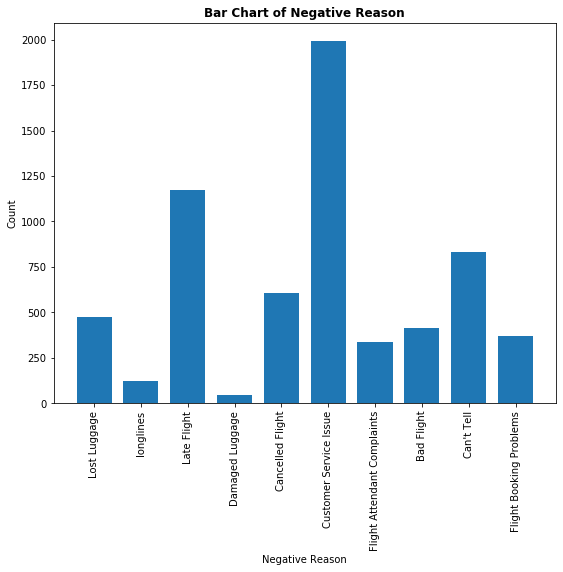

In [12]:
# create bar chart for counts of negativereason
labels = negreason_count.select('negativereason').where(W.col('negativereason')!='null').rdd.map(lambda row:row[0]).collect()
x = np.arange(len(labels))
# create bar chart
plt.figure(figsize=(9,7))
plt.bar(x,negreason_count.select('count').where(W.col('negativereason')!='null').rdd.map(lambda row:row[0]).collect(),width=0.75)
# set tick marks
plt.xticks(x,labels, rotation='90')
# create labels
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.title('Bar Chart of Negative Reason',weight='bold')
plt.show()

## `airline` Variable

In [13]:
# create data frame
airline_count = train_tweets.groupby('airline').count()
airline_count.show()

+--------------+-----+
|       airline|count|
+--------------+-----+
|         Delta| 1560|
|Virgin America|  356|
|        United| 2669|
|    US Airways| 2034|
|     Southwest| 1698|
|      American| 1906|
+--------------+-----+



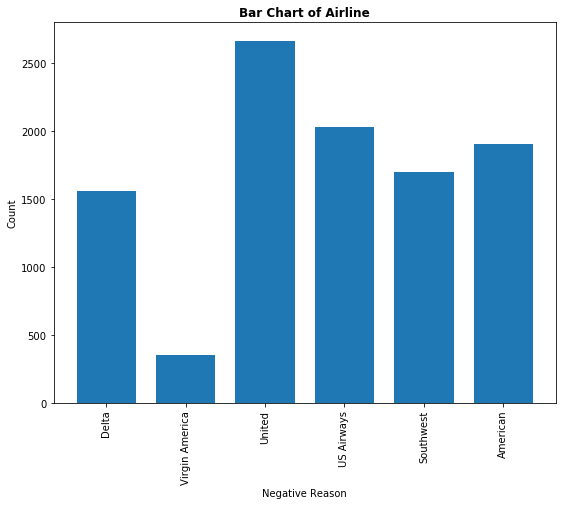

In [14]:
# create bar chart for counts of negativereason
labels = airline_count.select('airline').rdd.map(lambda row:row[0]).collect()
x = np.arange(len(labels))
# create bar chart
plt.figure(figsize=(9,7))
plt.bar(x,airline_count.select('count').rdd.map(lambda row:row[0]).collect(),width=0.75)
# set tick marks
plt.xticks(x,labels, rotation='90')
# create labels
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.title('Bar Chart of Airline',weight='bold')
plt.show()

## `text` Variable

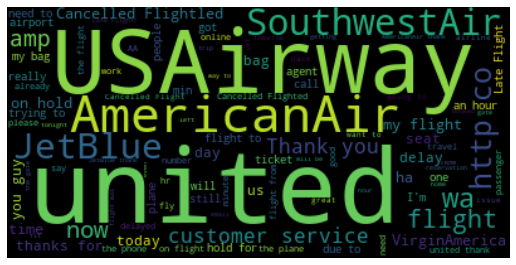

In [15]:
# create an RDD of the tweets
tweets_lst = train_tweets.select('text').rdd.flatMap(lambda row:row).collect()
# create a string of all of the tweets
tweets = ''
for tweet in tweets_lst:
    tweets += tweet
# create a word cloud
wordcloud = WordCloud().generate(tweets)
plt.figure(figsize=(9,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [16]:
# tokenize the text, @():;,.!?\-\/"
rt = RegexTokenizer().setInputCol('text').setOutputCol('text_vec')
# transform data
train_tweets = rt.transform(train_tweets)
# output dataframe
train_tweets.show(2)

+--------+--------------+----------+-------------+--------------------+--------------------+
|   label|negativereason|   airline|retweet_count|                text|            text_vec|
+--------+--------------+----------+-------------+--------------------+--------------------+
|negative|    Bad Flight|US Airways|            0|@USAirways yes.  ...|[@usairways, yes....|
|positive|          null|     Delta|            0|Sigh... “@JetBlue...|[sigh..., “@jetbl...|
+--------+--------------+----------+-------------+--------------------+--------------------+
only showing top 2 rows



In [17]:
# function for getting the length
def length(text):
    return len(text)
# udf for getting the length
length_udf = W.udf(lambda row: length(row), IntegerType())
# add column with length
train_tweets = train_tweets.withColumn('length', length_udf('text_vec'))
# output data frame
train_tweets.show(2)

+--------+--------------+----------+-------------+--------------------+--------------------+------+
|   label|negativereason|   airline|retweet_count|                text|            text_vec|length|
+--------+--------------+----------+-------------+--------------------+--------------------+------+
|negative|    Bad Flight|US Airways|            0|@USAirways yes.  ...|[@usairways, yes....|    20|
|positive|          null|     Delta|            0|Sigh... “@JetBlue...|[sigh..., “@jetbl...|     7|
+--------+--------------+----------+-------------+--------------------+--------------------+------+
only showing top 2 rows



In [18]:
# summary statistics for lengths
train_tweets.describe('length').show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|             10223|
|   mean|17.550132055169716|
| stddev|6.9413089852459615|
|    min|                 1|
|    max|                36|
+-------+------------------+



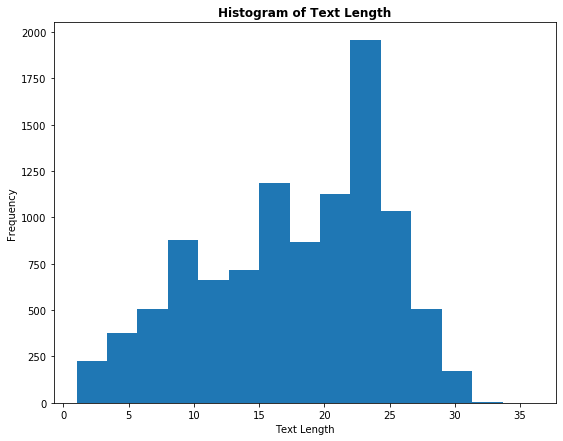

In [19]:
# create a list of the lengths
lengths_lst = list(train_tweets.select('length').rdd.flatMap(lambda row:row).collect())
# create a histogram of text length
plt.figure(figsize=(9,7))
plt.hist(lengths_lst,bins=15)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length',weight='bold')
plt.show()

## Most Mentioned Negative Reasons

In [20]:
negative_count = train_tweets.groupby('negativereason').count()
negative_count.show()

+--------------------+-----+
|      negativereason|count|
+--------------------+-----+
|        Lost Luggage|  473|
|           longlines|  121|
|         Late Flight| 1175|
|                null| 3852|
|     Damaged Luggage|   48|
|    Cancelled Flight|  607|
|Customer Service ...| 1992|
|Flight Attendant ...|  340|
|          Bad Flight|  412|
|          Can't Tell|  830|
|Flight Booking Pr...|  373|
+--------------------+-----+



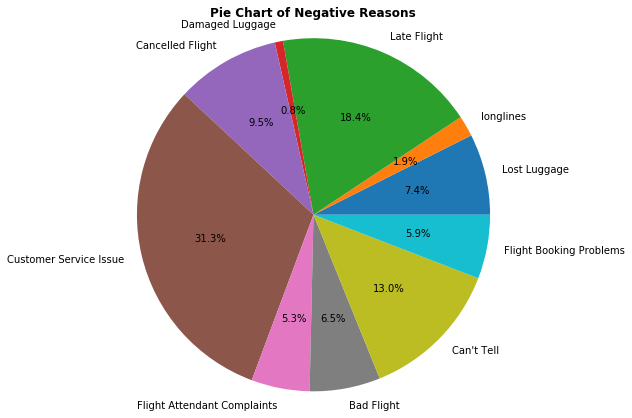

In [21]:
nreason = negative_count.select('negativereason').rdd.flatMap(lambda x: x).collect()
ncount = negative_count.select('count').rdd.flatMap(lambda x: x).collect()

nreason.remove(None) #remove None since it's meaningless to analyze
ncount.remove(3852) #remove None's corresponding count

plt.figure(figsize=(7,7))
plt.pie(ncount,labels=nreason,autopct='%1.1f%%') #draw a pie chart
plt.title('Pie Chart of Negative Reasons',weight='bold')
plt.axis('equal')
plt.show()

### Now, break it down to every flight company:

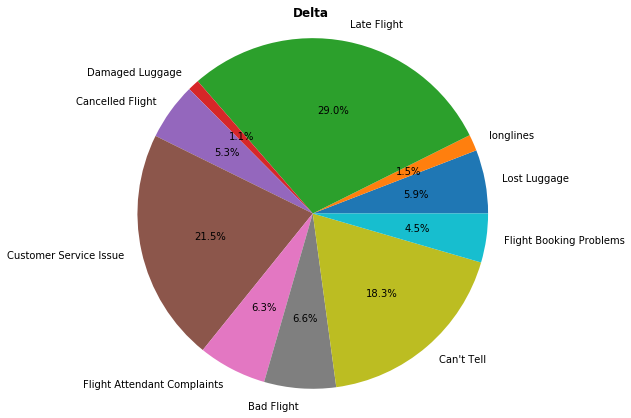

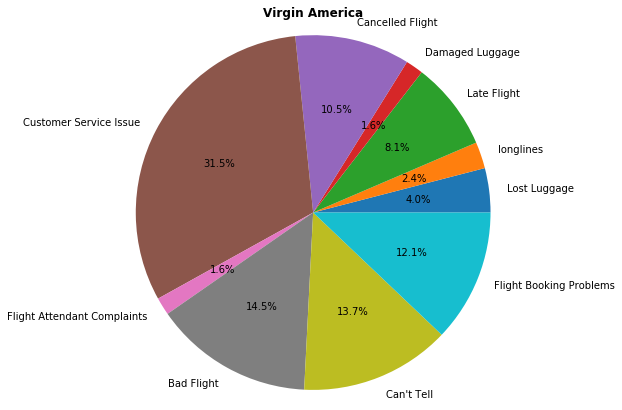

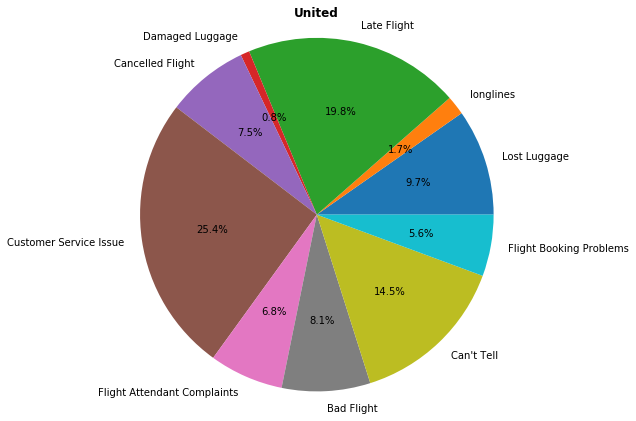

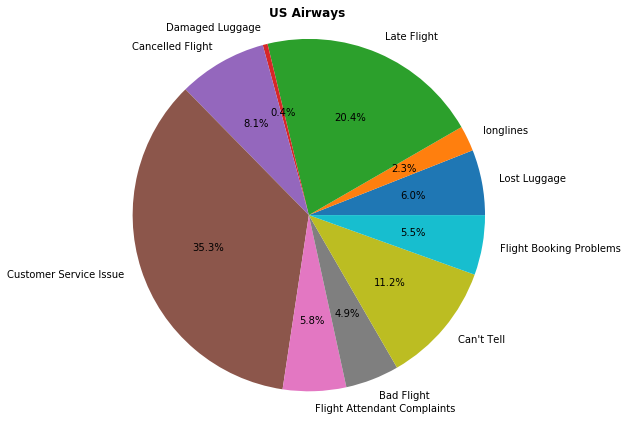

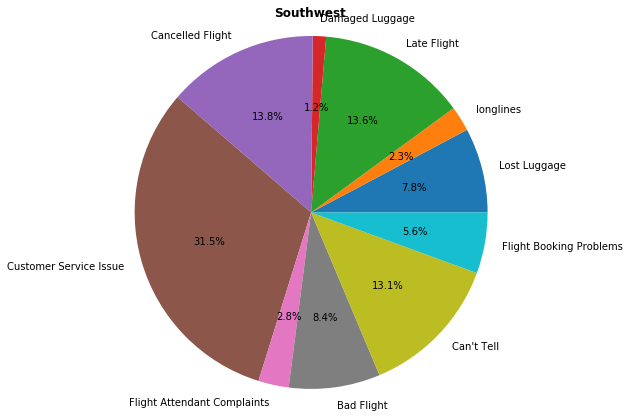

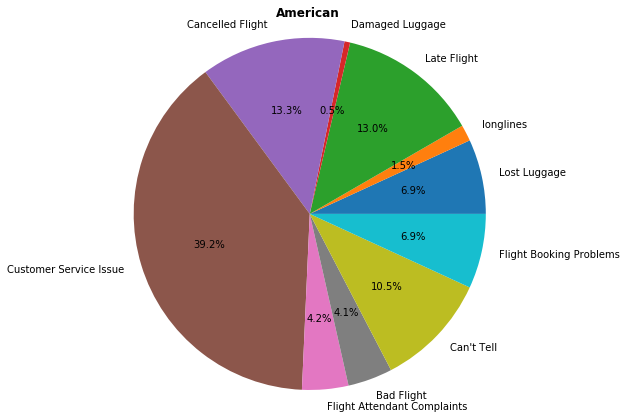

In [22]:
airways = ['Delta','Virgin America','United','US Airways','Southwest','American']

for a in airways:
    new = train_tweets.where(train_tweets.airline == a)
    new_count = new.groupby('negativereason').count()
    nreason = new_count.select('negativereason').rdd.flatMap(lambda x: x).collect()
    nreason.remove(None)
    ncount = new_count.select('count').where(W.col('negativereason')!='null').rdd.flatMap(lambda x: x).collect()
    plt.figure(figsize=(7,7))
    plt.pie(ncount,labels=nreason,autopct='%1.1f%%',radius=1)
    plt.axis('equal')
    plt.title(a,weight='bold')
    plt.show()

## Positive and Negative Tweets by Airline

In [23]:
# create data frame of counts for airline and label
airline = train_tweets.groupby('label','airline').count()
# output data frame
airline.show(2)

+--------+---------+-----+
|   label|  airline|count|
+--------+---------+-----+
|positive|Southwest|  873|
|negative| American| 1342|
+--------+---------+-----+
only showing top 2 rows



In [24]:
# create data frame for counts of positive tweets
pos_airline = airline.where(W.col('label') == 'positive').sort('airline')
pos_airline = pos_airline.withColumnRenamed('count','pos_count')
pos_airline.show(2)

+--------+--------+---------+
|   label| airline|pos_count|
+--------+--------+---------+
|positive|American|      564|
|positive|   Delta|      895|
+--------+--------+---------+
only showing top 2 rows



In [25]:
# create data frame for counts of negative tweets
neg_airline = airline.where(W.col('label') == 'negative').sort('airline')
neg_airline = neg_airline.withColumnRenamed('count','neg_count')
neg_airline = neg_airline.withColumnRenamed('airline','airline2')
neg_airline.show(2)

+--------+--------+---------+
|   label|airline2|neg_count|
+--------+--------+---------+
|negative|American|     1342|
|negative|   Delta|      665|
+--------+--------+---------+
only showing top 2 rows



In [26]:
# create data frame for proportions
prop_airline = pos_airline.join(neg_airline,(pos_airline.airline==neg_airline.airline2))
prop_airline = prop_airline.withColumn('count',W.col('pos_count')+W.col('neg_count'))
prop_airline = prop_airline.withColumn('pos_prop',W.col('pos_count')/W.col('count'))
prop_airline = prop_airline.withColumn('neg_prop',W.col('neg_count')/W.col('count'))
prop_airline.show(2)

+--------+--------------+---------+--------+--------------+---------+-----+------------------+-------------------+
|   label|       airline|pos_count|   label|      airline2|neg_count|count|          pos_prop|           neg_prop|
+--------+--------------+---------+--------+--------------+---------+-----+------------------+-------------------+
|positive|         Delta|      895|negative|         Delta|      665| 1560|0.5737179487179487|0.42628205128205127|
|positive|Virgin America|      232|negative|Virgin America|      124|  356| 0.651685393258427|0.34831460674157305|
+--------+--------------+---------+--------+--------------+---------+-----+------------------+-------------------+
only showing top 2 rows



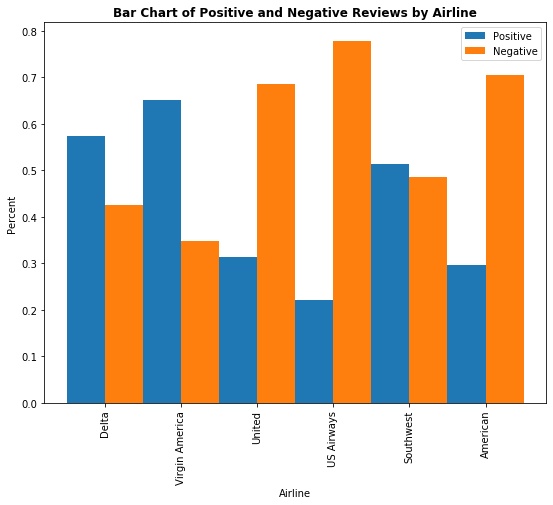

In [27]:
# create bar chart for proportions of positive and negative airline tweets
labels = prop_airline.select('airline').rdd.map(lambda row:row[0]).collect()
x = np.arange(len(labels))
# create bar chart
plt.figure(figsize=(9,7))
plt.bar(x-0.5/2,prop_airline.select('pos_prop').rdd.map(lambda row:row[0]).collect(),width=0.5)
plt.bar(x+0.5/2,prop_airline.select('neg_prop').rdd.map(lambda row:row[0]).collect(),width=0.5)
# set tick marks
plt.xticks(x,labels, rotation='90')
# create labels
plt.xlabel('Airline')
plt.ylabel('Percent')
plt.title('Bar Chart of Positive and Negative Reviews by Airline',weight='bold')
# create legend
plt.legend(['Positive','Negative'])
plt.show()

## Negative Reason by Airline

In [28]:
# create pivot table for negative reason and airline
neg_reason = train_tweets.groupby('airline').pivot('negativereason').count()
neg_reason = neg_reason.drop('null')
# output results
neg_reason.show(2)

+--------------+----------+----------+----------------+----------------------+---------------+---------------------------+-----------------------+-----------+------------+---------+
|       airline|Bad Flight|Can't Tell|Cancelled Flight|Customer Service Issue|Damaged Luggage|Flight Attendant Complaints|Flight Booking Problems|Late Flight|Lost Luggage|longlines|
+--------------+----------+----------+----------------+----------------------+---------------+---------------------------+-----------------------+-----------+------------+---------+
|         Delta|        44|       122|              35|                   143|              7|                         42|                     30|        193|          39|       10|
|Virgin America|        18|        17|              13|                    39|              2|                          2|                     15|         10|           5|        3|
+--------------+----------+----------+----------------+----------------------+------------

In [29]:
# convert data frame to pandas
neg_reason_pd = neg_reason.toPandas()
neg_reason_pd = neg_reason_pd.set_index('airline')
neg_reason_pd.head()

,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
airline,,,,,,,,,,
Delta,44,122,35,143,7,42,30,193,39,10
Virgin America,18,17,13,39,2,2,15,10,5,3
United,148,265,138,465,15,124,103,362,178,32
US Airways,78,177,129,559,7,92,87,324,95,37
Southwest,69,108,114,260,10,23,46,112,64,19


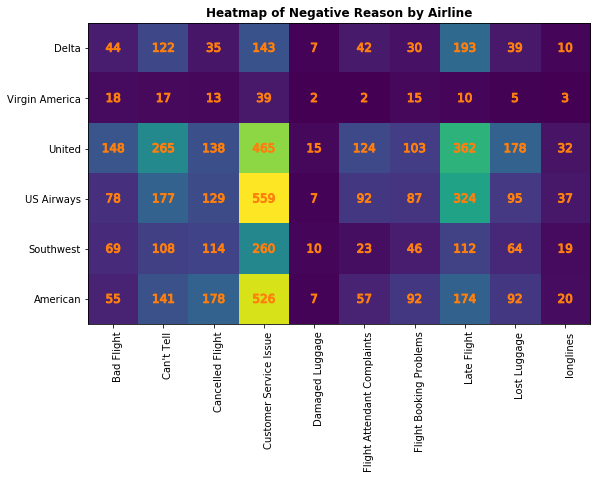

In [30]:
# create colormap for negative reason by airline
fig, ax = plt.subplots(figsize=(9,7))
# create chart
im = ax.imshow(neg_reason_pd)
# set tick marks
ax.set_xticks(np.arange(neg_reason_pd.shape[1]))
ax.set_yticks(np.arange(neg_reason_pd.shape[0]))
# set tick labels
ax.set_xticklabels(neg_reason.columns[1:])
ax.set_yticklabels(list(neg_reason_pd.index.values))
plt.setp(ax.get_xticklabels(),rotation=90,ha='right',rotation_mode='anchor')
# add numbers
for i in range(neg_reason_pd.shape[0]):
    for j in range(neg_reason_pd.shape[1]):
        text = ax.text(j,i,neg_reason_pd.iloc[i,j],ha='center',va='center',color='C1',fontsize=12)
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='C1'), path_effects.Normal()])
# set title
ax.set_title('Heatmap of Negative Reason by Airline',weight='bold')
plt.show()

## Retweeted Tweets

In [31]:
# create data frame
retweets = train_tweets.where(W.col('retweet_count') > 0)
retweets.show(2)

+--------+--------------------+--------+-------------+--------------------+--------------------+------+
|   label|      negativereason| airline|retweet_count|                text|            text_vec|length|
+--------+--------------------+--------+-------------+--------------------+--------------------+------+
|negative|Customer Service ...|American|            2|“@AmericanAir Tha...|[“@americanair, t...|    23|
|negative|Flight Attendant ...|  United|            1|@united you reall...|[@united, you, re...|    24|
+--------+--------------------+--------+-------------+--------------------+--------------------+------+
only showing top 2 rows



In [32]:
# create data frame for number of retweets for each label
retweet_label = retweets.groupby('label').count()
retweet_label2 = retweets.groupby('label').sum('retweet_count')
retweet_label2 = retweet_label2.withColumnRenamed('label','label2')
retweet_label = retweet_label.join(retweet_label2,retweet_label.label==retweet_label2.label2)
retweet_label.show()

+--------+-----+--------+------------------+
|   label|count|  label2|sum(retweet_count)|
+--------+-----+--------+------------------+
|positive|  129|positive|               293|
|negative|  408|negative|               606|
+--------+-----+--------+------------------+



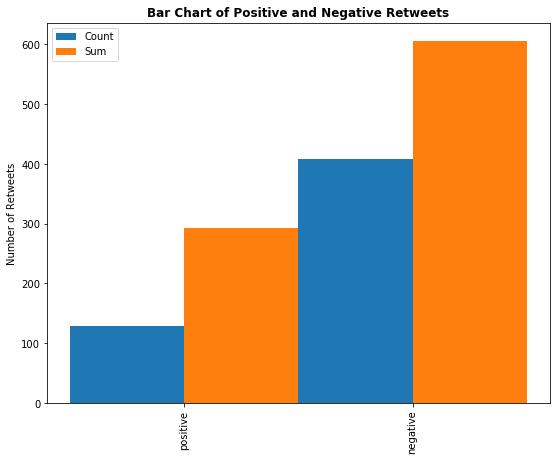

In [33]:
# create bar chart for proportions of positive and negative airline tweets
labels = retweet_label.select('label').rdd.map(lambda row:row[0]).collect()
x = np.arange(len(labels))
# create bar chart
plt.figure(figsize=(9,7))
plt.bar(x-0.5/2,retweet_label.select('count').rdd.map(lambda row:row[0]).collect(),width=0.5)
plt.bar(x+0.5/2,retweet_label.select('sum(retweet_count)').rdd.map(lambda row:row[0]).collect(),width=0.5)
# set tick marks
plt.xticks(x,labels, rotation='90')
# create labels
plt.ylabel('Number of Retweets')
plt.title('Bar Chart of Positive and Negative Retweets',weight='bold')
# create legend
plt.legend(['Count','Sum'])
plt.show()

In [34]:
# create data frame for number of retweets for each negative reason
retweet_neg = retweets.groupby('negativereason').count()
retweet_neg2 = retweets.groupby('negativereason').sum('retweet_count')
retweet_neg2 = retweet_neg2.withColumnRenamed('negativereason','negativereason2')
retweet_neg = retweet_neg.join(retweet_neg2,retweet_neg.negativereason==retweet_neg2.negativereason2)
retweet_neg.show()

+--------------------+-----+--------------------+------------------+
|      negativereason|count|     negativereason2|sum(retweet_count)|
+--------------------+-----+--------------------+------------------+
|        Lost Luggage|   26|        Lost Luggage|                28|
|           longlines|    4|           longlines|                 4|
|         Late Flight|   67|         Late Flight|                72|
|     Damaged Luggage|    2|     Damaged Luggage|                 5|
|    Cancelled Flight|   35|    Cancelled Flight|                53|
|Customer Service ...|  135|Customer Service ...|               164|
|Flight Attendant ...|   27|Flight Attendant ...|                30|
|          Bad Flight|   29|          Bad Flight|                33|
|          Can't Tell|   65|          Can't Tell|               184|
|Flight Booking Pr...|   18|Flight Booking Pr...|                33|
+--------------------+-----+--------------------+------------------+



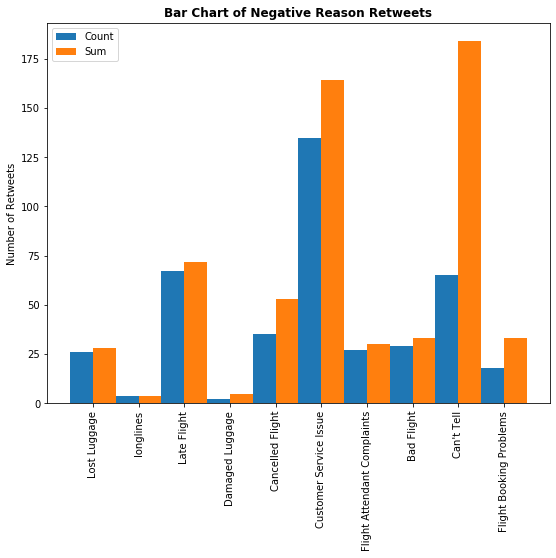

In [35]:
# create bar chart for proportions of positive and negative airline tweets
labels = retweet_neg.select('negativereason').rdd.map(lambda row:row[0]).collect()
x = np.arange(len(labels))
# create bar chart
plt.figure(figsize=(9,7))
plt.bar(x-0.5/2,retweet_neg.select('count').rdd.map(lambda row:row[0]).collect(),width=0.5)
plt.bar(x+0.5/2,retweet_neg.select('sum(retweet_count)').rdd.map(lambda row:row[0]).collect(),width=0.5)
# set tick marks
plt.xticks(x,labels, rotation='90')
# create labels
plt.ylabel('Number of Retweets')
plt.title('Bar Chart of Negative Reason Retweets',weight='bold')
# create legend
plt.legend(['Count','Sum'])
plt.show()

# PCA

In [36]:
# PCA
pca = PCA(k=20, inputCol="count_vec", outputCol="pcaFeatures")
model = pca.fit(train)
result = model.transform(train).select("pcaFeatures")
result.show(4,truncate=True)

+--------------------+
|         pcaFeatures|
+--------------------+
|[-1.0260470553257...|
|[0.25732535952510...|
|[-0.9252134414777...|
|[0.08632781135051...|
+--------------------+
only showing top 4 rows



In [37]:
# Explained Variance
var_exp = model.explainedVariance
var_exp

DenseVector([0.0559, 0.0455, 0.0337, 0.0305, 0.0278, 0.0233, 0.0176, 0.0164, 0.0148, 0.0131, 0.0116, 0.0112, 0.0107, 0.0102, 0.01, 0.0094, 0.0088, 0.0083, 0.0077, 0.0074])

In [38]:
# percentage of variance explained by first 20 principal components
print("Cumumlative percentage of variance explained by first 20 principal componets: ",sum(model.explainedVariance))

Cumumlative percentage of variance explained by first 20 principal componets:  0.3741399596453543


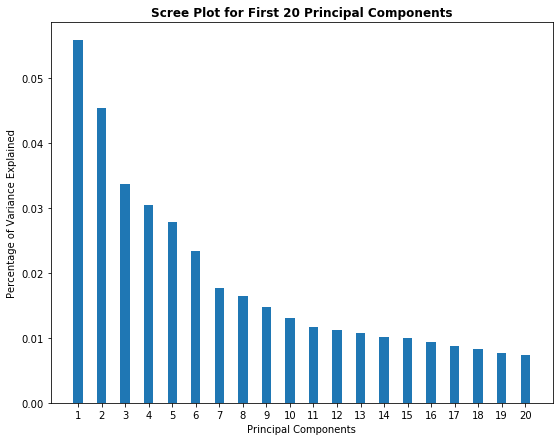

In [39]:
# plot
ids = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
plt.figure(figsize=(9,7))
plt.bar(ids, var_exp, width=0.4)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Variance Explained')
plt.title('Scree Plot for First 20 Principal Components',weight='bold')
plt.show()

In [40]:
# PCA (first 50 PCs)
pca = PCA(k=50, inputCol="count_vec", outputCol="pcaFeatures")
model = pca.fit(train)
result = model.transform(train).select("pcaFeatures")

# percentage of variance explained by first 50 principal components
print("Cumumlative percentage of variance explained by first 50 principal componets: ",sum(model.explainedVariance))

Cumumlative percentage of variance explained by first 50 principal componets:  0.5316574673917811


In [41]:
# PCA (first 100 PCs)
pca = PCA(k=100, inputCol="count_vec", outputCol="pcaFeatures")
model = pca.fit(train)
result = model.transform(train).select("pcaFeatures")

# percentage of variance explained by first 100 principal components
print("Cumumlative percentage of variance explained by first 100 principal componets: ",sum(model.explainedVariance))

Cumumlative percentage of variance explained by first 100 principal componets:  0.6883034646314963


In [42]:
# PCA (first 150 PCs)
pca = PCA(k=150, inputCol="count_vec", outputCol="pcaFeatures")
model = pca.fit(train)
result = model.transform(train).select("pcaFeatures")

# percentage of variance explained by first 150 principal components
print("Cumumlative percentage of variance explained by first 150 principal componets: ",sum(model.explainedVariance))

Cumumlative percentage of variance explained by first 150 principal componets:  0.788968399502866


In [43]:
# PCA (first 200 PCs)
pca = PCA(k=200, inputCol="count_vec", outputCol="pcaFeatures")
model = pca.fit(train)
result = model.transform(train).select("pcaFeatures")

# percentage of variance explained by first 200 principal components
print("Cumumlative percentage of variance explained by first 200 principal componets: ",sum(model.explainedVariance))

Cumumlative percentage of variance explained by first 200 principal componets:  0.8627326379302294


# Latent Dirichlet Allocation

## Tune Number of Topics

In [44]:
# number of topics to try
ks1 = [2,5,10,20]
max_iter1 = [10,20,50,100]
log_likelihoods1 = []
# obtain log likelihoods of the LDA for each number of topics
for k in ks1:
    for m in max_iter1:
        lda_k1 = LDA(featuresCol='count_vec').setK(k).setMaxIter(m).setSeed(414)
        lda_model_k1 = lda_k1.fit(train)
        log_likelihoods1.append([lda_model_k1.logLikelihood(test),k,m])

In [45]:
max_log = log_likelihoods1[0]
for i in range(len(log_likelihoods1)):
    if log_likelihoods1[i][0] > max_log[0]:
        max_log = log_likelihoods1[i]
print("Largest log likelihood: ",max_log[0])
print("Best number of clusters: ",max_log[1])
print("Best max iteration: ",max_log[2])

Largest log likelihood:  -148887.91486072322
Best number of clusters:  2
Best max iteration:  100


## Final Clustering Model

In [46]:
# create final LDA model
lda2 = LDA(featuresCol='count_vec',k=2).setMaxIter(100).setSeed(968)
lda_model2 = lda2.fit(train)
lda_model2.logLikelihood(train)

-346092.08072387206

In [47]:
# obtain topic distribition for each row of the train dataframe
train_topics2 = lda_model2.transform(train)
train_topics2.select('topicDistribution').show(5,truncate=False)

+----------------------------------------+
|topicDistribution                       |
+----------------------------------------+
|[0.6759524516631547,0.3240475483368454] |
|[0.17468325046272615,0.8253167495372739]|
|[0.6964594465038952,0.30354055349610476]|
|[0.3771679014512924,0.6228320985487076] |
|[0.4422234468403385,0.5577765531596616] |
+----------------------------------------+
only showing top 5 rows



In [48]:
# obtain term indices for each topic
topics2 = lda_model2.describeTopics(300)
topics2.show(2)

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[1, 4, 0, 6, 9, 1...|[0.06736675732572...|
|    1|[0, 2, 3, 5, 7, 8...|[0.07520400566746...|
+-----+--------------------+--------------------+



In [49]:
# function for converting index to word
def index_to_word(row):
    new_row = []
    for item in row:
        new_row.append(vocab[item])
    return new_row
# udf for converting index to word
index_to_word_udf = W.udf(lambda row: index_to_word(row), ArrayType(StringType()))
# add column of words corresponding to each index
topics2 = topics2.withColumn('topic_words', index_to_word_udf('termIndices'))
# output dataframe
topics2.show(2)

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|         topic_words|
+-----+--------------------+--------------------+--------------------+
|    0|[1, 4, 0, 6, 9, 1...|[0.06736675732572...|[united, southwes...|
|    1|[0, 2, 3, 5, 7, 8...|[0.07520400566746...|[flight, usairway...|
+-----+--------------------+--------------------+--------------------+



## Word Cloud

In [50]:
# function for whole number of weights (used for word cloud frequencies)
def weights_whole(row):
    weights = []
    for item in row:
        weights.append(int(item*10000))
    return weights
# udf for whole number of weights
weights_whole_udf = W.udf(lambda row: weights_whole(row), ArrayType(IntegerType()))
# add column with whole number of weights
topics2 = topics2.withColumn('weights_whole', weights_whole_udf('termWeights'))
# output dataframe
topics2.show(2)

+-----+--------------------+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|         topic_words|       weights_whole|
+-----+--------------------+--------------------+--------------------+--------------------+
|    0|[1, 4, 0, 6, 9, 1...|[0.06736675732572...|[united, southwes...|[673, 428, 314, 2...|
|    1|[0, 2, 3, 5, 7, 8...|[0.07520400566746...|[flight, usairway...|[752, 569, 554, 4...|
+-----+--------------------+--------------------+--------------------+--------------------+



In [51]:
# function for creating word cloud
def wordcloudplot(lda,topics):
    for k in range(lda.getK()):
        topick = topics.where(W.col('topic') == k)
        topick_dict = {}
        for i,v in zip(topick.select('topic_words').rdd.map(lambda x:x[0]).collect()[0],topick.select('weights_whole').rdd.map(lambda x:x[0]).collect()[0]):
            topick_dict[i] = v
        cloud = WordCloud()
        plt.figure(figsize=(9,7))
        cloud.generate_from_frequencies(topick_dict)
        plt.imshow(cloud)
        plt.axis("off")
        plt.margins(x=0, y=0)
        plt.show()

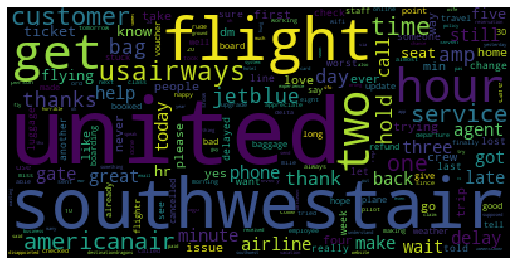

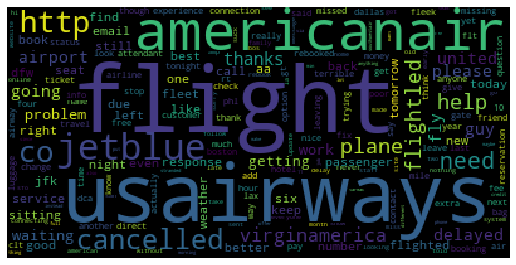

In [52]:
# create word cloud for each topic
wordcloudplot(lda2,topics2)